# Continuous Control

---

In this notebook, we will implement a PPO agent in order to solve the environment of the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unityagents import UnityEnvironment
import progressbar as pb

# check which device is being used. 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ",device)

using device:  cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
for t in range(500):
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04699999894946814


### 4. Train an agent using PPO

#### 4.1. Policy implementation

Here, we implement our policy

In [6]:
class Policy(nn.Module):

    def __init__(self, state_size, action_size):
        super(Policy, self).__init__()        
        # actor network
        self.state_size = state_size
        self.action_size = action_size
        self.fc1_actor = nn.Linear(self.state_size, 512)
        self.fc2_actor = nn.Linear(512, 512)
        self.fc3_actor = nn.Linear(512, action_size)
        
        #critic network
        self.fc1_critic = nn.Linear(self.state_size, 512)
        self.fc2_critic = nn.Linear(512, 512)
        self.fc3_critic = nn.Linear(512, 1)
        
        self.std = nn.Parameter(torch.ones(1, self.action_size))
        self.to(device)

    def forward(self, x, action=None):
        x = torch.Tensor(x).cuda()
        actor = F.relu(self.fc1_actor(x))
        actor = F.relu(self.fc2_actor(actor))
        mean = F.tanh(self.fc3_actor(actor))
        
        critic = F.relu(self.fc1_critic(x))
        critic = F.relu(self.fc2_critic(critic))
        v = self.fc3_critic(critic)
        
        dist = torch.distributions.Normal(mean, self.std)
        
        if action is None:
            action = dist.sample()
        log_prob = torch.sum(dist.log_prob(action), dim=1, keepdim=True)
        entropy = torch.Tensor(np.zeros((log_prob.size(0), 1)))
        return action, log_prob, entropy, v

# instanciate the policy
policy =Policy(state_size, action_size).to(device)

#### 4.2. Function Definitions
Here we will define key functions for training.

First, we need a function to collect trajectories:

In [7]:
def collect_trajectories(env, policy, tmax=2000, nrand=2):
    
    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]
    value_list=[]
    is_done_list=[]
    
    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    n = len(env_info.agents)
    
    #get first states
    state = env_info.vector_observations
    
    while True:
        action, log_prob, _, v = policy(state)
        action_list.append(action.detach())
        log_prob = log_prob.detach()
        v = v.detach()
        env_info = env.step(action.cpu().numpy())[brain_name]
        next_state = env_info.vector_observations
        reward = np.asarray(env_info.rewards)
        reward = torch.from_numpy(reward).cuda().float().unsqueeze(1)
        is_done = np.array([1 if t else 0 for t in env_info.local_done])
        is_done = torch.Tensor(1-is_done).cuda().float().unsqueeze(1)
        # store the result
        state_list.append(state)
        reward_list.append(reward)
        prob_list.append(log_prob)
        is_done_list.append(is_done)
        value_list.append(v)
        state = next_state
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if np.any(env_info.local_done):
            break
    
    # return log_probs, states, rewards, actions, critic_values, dones
    return prob_list, state_list, reward_list, action_list, value_list, is_done_list

Then we will implement the clipped surrogate function according to these equations:

$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [8]:
def clipped_surrogate(policy, old_probs, states, rewards, actions, values, is_done,
                      discount=0.995,
                      epsilon=0.1, beta=0.01, tau = 0.95, gradient_clip=0.2):
    
    r = torch.tensor(values[-1], dtype=torch.float, device=device)
    returns = [0 for i in range(len(values)-1)]
    advantages = [0 for i in range(len(values)-1)]
    a = torch.Tensor(np.zeros((20, 1))).cuda().float()
    
    for i in reversed(range(len(states) - 1)):
        
        next_value = values[i+1]
        r = rewards[i] + discount * is_done[i] * r
        td_error = rewards[i] + discount * next_value.detach() * is_done[i] - values[i].detach()
        a = a * tau * discount * is_done[i] + td_error
        returns[i] = r
        advantages[i] = a
    
    advantages = torch.cat(advantages, dim=0).cuda().float()
    advantages = (advantages - advantages.mean()) / advantages.std()
    
    values = values[:-1]
    states = np.asarray(states[:-1])
    actions = actions[:-1]
    states = torch.cat([torch.tensor(state).float() for state in states], dim=0)
    actions = torch.cat([torch.tensor(action).float() for action in actions], dim=0)
    old_probs = torch.cat(old_probs[:-1],dim=0).cuda().float()
    
    # run the policy
    _, new_probs, entropy_loss, new_values = policy(states, actions)
    
    #compute the policy loss
    ratio = (new_probs - old_probs).exp()
    obj = ratio * advantages
    obj_clipped = ratio.clamp(1.0 - epsilon, 1.0 + epsilon) * advantages
    policy_loss = -torch.min(obj, obj_clipped).mean(0) - beta * entropy_loss.mean().cuda().float()
    
    #compute the value loss
    value_loss = 0.5 * (torch.cat(returns, dim=0) - new_values).pow(2).mean()
    
    optimizer.zero_grad()
    (policy_loss + value_loss).backward()
    nn.utils.clip_grad_norm_(policy.parameters(), gradient_clip)
    optimizer.step()
    return

#### 4.3. Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing.

In [10]:
# training loop max iterations
episode = 2000

widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 1000
SGD_epoch = 30
gradient_clip = 0.2
# keep track of progress
mean_rewards = []
scores_window = deque(maxlen=100)
#mean score for plotting
mean_score = []

# we use the adam optimizer with learning rate 3e-4
optimizer = optim.Adam(policy.parameters(), lr=3e-4)

for i_episode in range(episode):

    # collect trajectories
    old_probs, states, rewards, actions, values, is_done = collect_trajectories(env, policy, tmax=tmax)
    #compute total rewards    
    total_rewards = np.sum(torch.stack(rewards).cpu().numpy(), axis=0)

    # gradient ascent step
    for _ in range(SGD_epoch):        
        clipped_surrogate(policy, old_probs, states, rewards, actions, values, is_done,
                                          epsilon=epsilon, beta=beta)
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    scores_window.append(np.mean(total_rewards))
    mean_score.append(np.mean(scores_window))
    
    # display some progress every 20 iterations
    if (i_episode+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(i_episode+1,np.mean(total_rewards)))
    if np.mean(scores_window)>=30.0 and i_episode >= 99:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(policy.state_dict(), 'ppo_checkpoint.pth')
            break    
    # update progress widget bar
    timer.update(i_episode+1)
    
timer.finish()

Episode: 20, score: 1.379500


Episode: 40, score: 5.080997


Episode: 60, score: 18.136047


Episode: 80, score: 34.846413


Episode: 100, score: 39.172020


Episode: 120, score: 39.383015



Environment solved in 136 episodes!	Average Score: 30.02


### 5. Plot Results

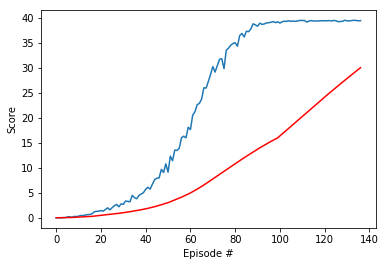

In [12]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_rewards)), mean_rewards)
plt.plot(np.arange(len(mean_score)), mean_score, color='red')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch a Smart Agent!

In the next code cell, we will load the trained weights from file to watch the agent playing!

In [13]:
# load the weights from file
policy.load_state_dict(torch.load('ppo_checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions, _, _, _ = policy(states)                  # get an action (for each agent)
    env_info = env.step(actions.cpu().numpy())[brain_name] # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 39.44049911843613


### 6. Close the environment!

In [14]:
env.close()